# CM4044 Project 2

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [39]:
# Drop columns with correlation above defined threshold
def drop_correlated_cols(df, cols_features, threshold):
    """
    Return a new dataframe, df, with columns correlated above threshold removed.
    The column removed is the right most one.
    """
    cols_to_remove = set()
    correlations_abs = df[cols_features].corr().abs()
    for i in range(len(correlations_abs.columns)):
        for j in range(i):
            if (correlations_abs.iloc[i, j] >= threshold) and (correlations_abs.columns[j] not in cols_to_remove):
                colname = correlations_abs.columns[i]
                if colname in df.columns:
                    cols_to_remove.add(colname)
                    df.drop(colname, axis=1, inplace=True)
    return df

In [ ]:
df = pd.read_csv('enthalpy_data.csv', sep=',', na_values=['na', 'NA', 'N/A'])

# Drop columns with na
df.dropna(axis='columns', inplace=True)

# Drop columns that have only a single value (variance = 0)
count_unique = df.apply(pd.Series.nunique)
cols_to_drop = count_unique[count_unique == 1].index
df.drop(columns=cols_to_drop, inplace=True)

# Drop highly correlated features
cols_features = df.columns[2:]
df = drop_correlated_cols(df, cols_features, 0.9)

# Drop specific columns - done because of extremely low variance
cols_specific = ['Eig15_AEA(ed)']
df.drop(cols_specific, axis=1, inplace=True)

# Save dataset
df.to_csv('enthalpy_data_processed.csv', index=False)

In [55]:
df.head(5)

,Smiles,Enthalpy,Mol,Descriptors
0,CCCCCCCCCCCCCCCCCC,-99.091888,<rdkit.Chem.rdchem.Mol object at 0x14f45e650>,"[2.2939033705287217, 2.2939033705287217, 1.373..."
1,CCCCCCCCCCCCCCCC,-89.480000,<rdkit.Chem.rdchem.Mol object at 0x14f45e7a0>,"[2.2902201417224934, 2.2902201417224934, 1.372..."
2,CCCCC(C)(C)CC(C)(C)CCCC,-87.619600,<rdkit.Chem.rdchem.Mol object at 0x14f45e6c0>,"[2.440829081632653, 2.440829081632653, 0.53497..."
3,CCCC(C)(CC)CC(C)(CC)CCC,-82.958983,<rdkit.Chem.rdchem.Mol object at 0x14f45e110>,"[2.486180555555556, 2.486180555555556, 0.57805..."
4,CCCCCCCCCCCCCCC,-84.390000,<rdkit.Chem.rdchem.Mol object at 0x14f45e2d0>,"[2.2879979195002713, 2.2879979195002713, 1.372..."


In [56]:
# calculate the molecules descriptors and append them to the df object
df = pd.read_csv('enthalpy_data_processed.csv', sep=',', na_values=['na', 'NA', 'N/A'])

df = df[['Smiles', 'Enthalpy(kcal)']]

df['Mol'] = df['Smiles'].apply(Chem.MolFromSmiles)

descriptor_names = [desc_name for desc_name, _ in Descriptors._descList]
# print(descriptor_names)
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_names)
def calc_all_descriptors(mol):
    if mol is None:
        return [None] * len(descriptor_names)
    return list(calculator.CalcDescriptors(mol))
df['Descriptors'] = df['Mol'].apply(calc_all_descriptors)
df.rename(columns={'Enthalpy(kcal)': 'Enthalpy'}, inplace=True)

df = df.drop(columns=['Mol'])

In [57]:
# convert into df in numpy array
X = np.array(list(df['Descriptors']))
y = df['Enthalpy'].to_numpy()

st = StandardScaler()
X = st.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, RandomizedSearchCV
np.random.seed(0)

### Linear Regression

Mean R-Squared: 0.992
Mean MAE: 1.257

Linear Regression R-Squared: 0.996
Linear Regression MAE: 1.027


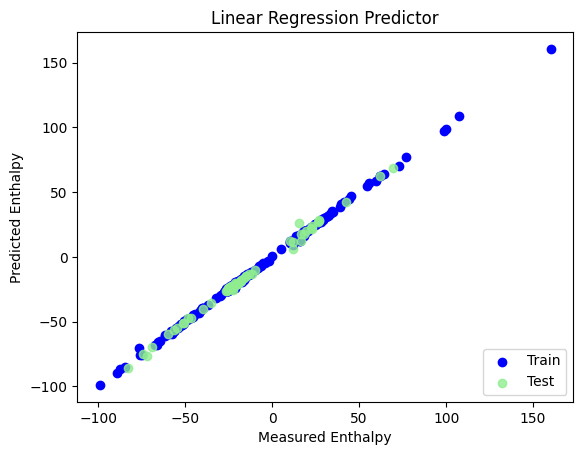

In [69]:
lr = LinearRegression()

kf = KFold(n_splits=10, shuffle=True, random_state=0)

# Cross validation
cv_results = cross_validate(
    lr,
    X_train,
    y_train,
    cv=kf,
    scoring={'r2': 'r2', 'mae': 'neg_mean_absolute_error'},
    return_train_score=True
)

# print("Cross-validation R-Squared (test):", cv_results['test_r2'])
# print("Cross-validation MAE (test):", -cv_results['test_mae'])
print(f"Mean R-Squared: {np.mean(cv_results['test_r2']):.3f}")
print(f"Mean MAE: {-np.mean(cv_results['test_mae']):.3f}\n")

lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

#model evaluation
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression R-Squared: {(r2_lr):.3f}")
print(f"Linear Regression MAE: {(mae_lr):.3f}")

plt.scatter(y_train, lr.predict(X_train), label = 'Train', c='blue')
plt.title('Linear Regression Predictor')
plt.xlabel('Measured Enthalpy')
plt.ylabel('Predicted Enthalpy')
plt.scatter(y_test, lr.predict(X_test),c='lightgreen', label='Test', alpha = 0.8)
plt.legend(loc=4)
#plt.savefig('Linear Regression Predictor.png', dpi=300)
plt.show()

### SVR

In [ ]:
from sklearn.svm import SVR

np.random.seed(0)

# Define search space
Cs = [1, 10, 100, 500, 1000]
epsilons = [0.1, 0.15, 0.2, 0.25, 0.3]

# Setup the grid to be searched over
param_grid = dict(C=Cs, epsilon=epsilons)

# Define grid search
grid_search = GridSearchCV(SVR(kernel='rbf', gamma='auto'), param_grid, cv=kf,
                           n_jobs=20, verbose=1, scoring='neg_mean_absolute_error')

# Find best parameters
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
{'C': 500, 'epsilon': 0.1}
-2.185555068838425


Fitting 10 folds for each of 505 candidates, totalling 5050 fits
{'C': 421, 'epsilon': 0.05}
-2.1648631392222883
SVR R-Squared: 0.9948
SVR MAE: 1.2826


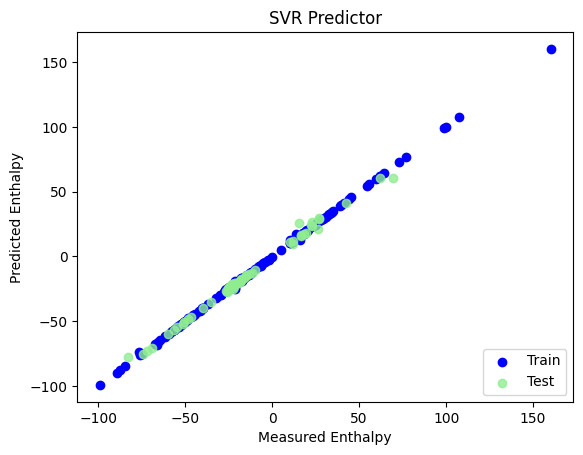

In [ ]:
# Redefine search space
Cs = list(range(400, 501))
epsilons = [0.05, 0.075, 0.1, 0.125, 0.15]

# Setup the grid to be searched over
param_grid = dict(C=Cs, epsilon=epsilons)

# Define grid search
grid_search = GridSearchCV(SVR(kernel='rbf', gamma='auto'), param_grid, cv=kf,
                           n_jobs=20, verbose=1, scoring='neg_mean_absolute_error')

# Find best parameters
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Retrain model with best parameters found from grid search
best_params = grid_search.best_params_
svr = SVR(kernel='rbf', gamma='auto', C=best_params['C'], epsilon=best_params['epsilon'])
svr.fit(X_train, y_train)

y_pred_svr = svr.predict(X_test)

# model evaluation
r2_svr = r2_score(y_test, y_pred_svr)
mae_svr = mean_absolute_error(y_test, y_pred_svr)
print(f"SVR R-Squared: {(r2_svr):.4f}")
print(f"SVR MAE: {(mae_svr):.4f}")

plt.scatter(y_train, svr.predict(X_train), label = 'Train', c='blue')
plt.title('SVR Predictor')
plt.xlabel('Measured Enthalpy')
plt.ylabel('Predicted Enthalpy')
plt.scatter(y_test, svr.predict(X_test),c='lightgreen', label='Test', alpha = 0.8)
plt.legend(loc=4)
#plt.savefig('SVR Predictor.png', dpi=300)
plt.show()

Fitting 10 folds for each of 50 candidates, totalling 500 fits
{'n_estimators': 315, 'learning_rate': 0.02}
-2.312145515681528
XGB R-Squared: 0.9912
XGB MAE: 1.4750


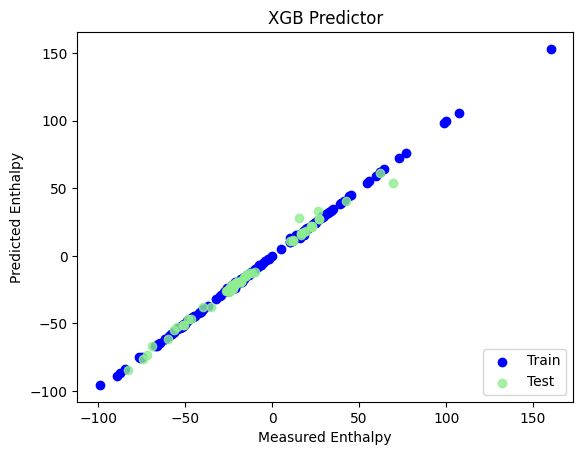

In [76]:
import xgboost as xgb

np.random.seed(0)

# Redefine search space
n_estimators = list(range(200, 401))
learning_rate = [0.01, 0.02, 0.03, 0.04, 0.05]

# Setup the grid to be searched over
param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate)

# Define grid search
grid_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=0), param_grid, cv=kf,
                           n_jobs=20, verbose=1, scoring='neg_mean_absolute_error',
                           random_state=0, n_iter=50)

# Find best parameters
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

# Retrain model with best parameters found from grid search
best_params = grid_search.best_params_
xg = xgb.XGBRegressor(random_state=0, n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'])
xg.fit(X_train, y_train)

y_pred_xgb = xg.predict(X_test)

# model evaluation
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGB R-Squared: {(r2_xgb):.4f}")
print(f"XGB MAE: {(mae_xgb):.4f}")

plt.scatter(y_train, xg.predict(X_train), label = 'Train', c='blue')
plt.title('XGB Predictor')
plt.xlabel('Measured Enthalpy')
plt.ylabel('Predicted Enthalpy')
plt.scatter(y_test, xg.predict(X_test),c='lightgreen', label='Test', alpha = 0.8)
plt.legend(loc=4)
#plt.savefig('XGB Predictor.png', dpi=300)
plt.show()